Importing Necessary Libraries:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import KBinsDiscretizer

Loading the datasets:

In [65]:
# Load datasets
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
weather_data = pd.read_csv('/content/drive/MyDrive/Weather Dataset 2022.csv')
print(weather_data.head())
turnstile_data = pd.read_csv('/content/drive/MyDrive/MTA_Subway_Turnstile_Data_2022.csv')
print(turnstile_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2022-01-01   9.7   6.4  11.6  24.0   NaN   150   7.8   NaN  1008.1   NaN
1  2022-01-02   9.1   1.8  13.4   5.2   NaN   315  15.7   NaN  1005.6   NaN
2  2022-01-03  -1.9  -4.6   1.3   2.5   NaN     1  22.7   NaN  1019.4   NaN
3  2022-01-04  -2.8  -6.2   0.8   0.0   NaN   270  11.1   NaN  1028.1   NaN
4  2022-01-05   3.0  -1.5   7.9   3.3   NaN   224  13.3   NaN  1014.3   NaN
    C/A  Unit       SCP Line Name Division        Date      Time Description  \
0  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  03:00:00     REGULAR   
1  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  07:00:00     REGULAR   
2  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  11:00:00     REGULAR   
3  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  15:00:00     REGULAR   
4  A002  R051  

Used Random Sampling because of large data:

In [6]:
# Randomly sample rows without replacement
turnstile_data = turnstile_data.sample(n=500000, random_state=42)
print("Data reduced")


Data reduced


Cleaning Turnstile Data:

In [7]:
# Clean turnstile data
turnstile_data.columns = turnstile_data.columns.str.strip()
turnstile_data.rename(columns={'Entries': 'ENTRIES', 'Exits': 'EXITS'}, inplace=True)

Calculate Daily Entries and Exits:

In [8]:
# Calculate daily entries and exits
turnstile_data['Date'] = pd.to_datetime(turnstile_data['Date'])
turnstile_data = turnstile_data.sort_values(by=['C/A', 'Unit', 'SCP', 'Date', 'Time'])
turnstile_data['Daily Entries'] = turnstile_data.groupby(['C/A', 'Unit', 'SCP'])['ENTRIES'].diff().fillna(0)
turnstile_data['Daily Exits'] = turnstile_data.groupby(['C/A', 'Unit', 'SCP'])['EXITS'].diff().fillna(0)

In [9]:
# Filter out negative values
turnstile_data = turnstile_data[(turnstile_data['Daily Entries'] >= 0) & (turnstile_data['Daily Exits'] >= 0)]

Handling outliers and Cleaning data:

In [11]:
# Remove outliers using IQR for 'Daily Entries' and 'Daily Exits'
Q1 = turnstile_data[['Daily Entries', 'Daily Exits']].quantile(0.25)
Q3 = turnstile_data[['Daily Entries', 'Daily Exits']].quantile(0.75)
IQR = Q3 - Q1

In [12]:
# Keep rows within 1.5*IQR range
turnstile_data = turnstile_data[~((turnstile_data[['Daily Entries', 'Daily Exits']] < (Q1 - 1.5 * IQR)) |
                                  (turnstile_data[['Daily Entries', 'Daily Exits']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [13]:
print(f"Data shape before outlier removal: {turnstile_data.shape}")

Data shape before outlier removal: (424845, 12)


Cleaning Weather Dataset:

In [15]:
# Clean weather data
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y-%m-%d')

Merging the datasets on "date" feature:

In [18]:
# Merge the datasets on the date
merged_data = pd.merge(turnstile_data, weather_data, left_on='Date', right_on='date', how='left')

Dropping NaN columns:

In [19]:
# Drop columns that are entirely NaN in merged data
merged_data = merged_data.drop(columns=['snow', 'wpgt', 'tsun'], errors='ignore')

In [20]:
# Check for NaN values in important columns
print("NaN values in merged data after dropping NaN columns:\n", merged_data.isna().sum())


NaN values in merged data after dropping NaN columns:
 C/A              0
Unit             0
SCP              0
Line Name        0
Division         0
Date             0
Time             0
Description      0
ENTRIES          0
EXITS            0
Daily Entries    0
Daily Exits      0
date             0
tavg             0
tmin             0
tmax             0
prcp             0
wdir             0
wspd             0
pres             0
dtype: int64


In [21]:
# Remove any remaining rows with NaN values
merged_data = merged_data.dropna()

In [22]:
# Ensure there is data to work with after dropping NaN values
if not merged_data.empty:
    print(f"Turnstile Data Shape: {turnstile_data.shape}")
    print(f"Weather Data Shape: {weather_data.shape}")
    print(f"Merged Data Shape: {merged_data.shape}")

Turnstile Data Shape: (424845, 12)
Weather Data Shape: (365, 11)
Merged Data Shape: (424845, 20)


Feature Engineering

Creating features "is_cold" and "is_rainy"

In [25]:
# Create binary features for weather conditions
merged_data['Is_Cold'] = merged_data['tavg'].apply(lambda x: 1 if x < 32 else 0)
merged_data['Is_Rainy'] = merged_data['prcp'].apply(lambda x: 1 if x > 0 else 0)

In [26]:
# Ensure features are prepared
merged_data['Hour'] = merged_data['Time'].apply(lambda x: pd.to_datetime(x).hour)
merged_data['Day_of_Week'] = merged_data['Date'].dt.dayofweek

<ipython-input-67-ed60af48de33>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  correlation_matrix_filled = correlation_matrix.fillna(method='ffill')


Correlation matrix:
                Daily Entries  Is_Cold  Is_Rainy      tavg      prcp      Hour  \
Daily Entries       1.000000      NaN  0.004101  0.021512 -0.002703  0.010771   
Is_Cold                  NaN      NaN       NaN       NaN       NaN       NaN   
Is_Rainy            0.004101      NaN  1.000000  0.166308  0.360919 -0.010892   
tavg                0.021512      NaN  0.166308  1.000000 -0.000854 -0.060045   
prcp               -0.002703      NaN  0.360919 -0.000854  1.000000 -0.001118   
Hour                0.010771      NaN -0.010892 -0.060045 -0.001118  1.000000   
Day_of_Week         0.009978      NaN  0.002941 -0.007524 -0.015714  0.004583   

               Day_of_Week  
Daily Entries     0.009978  
Is_Cold                NaN  
Is_Rainy          0.002941  
tavg             -0.007524  
prcp             -0.015714  
Hour              0.004583  
Day_of_Week       1.000000  


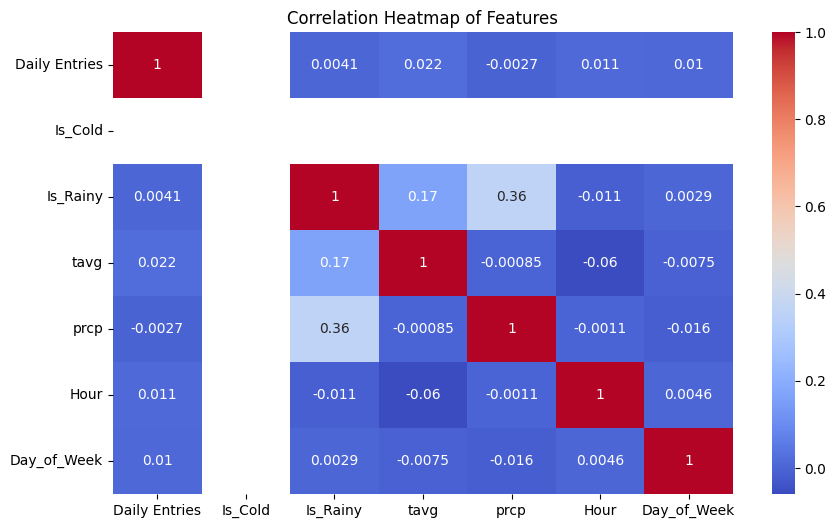

In [67]:
# Correlation Heatmap after removing NaN columns and rows
correlation_matrix_filled = correlation_matrix.fillna(method='ffill')

plt.figure(figsize=(10, 6))
correlation_matrix = merged_data[['Daily Entries', 'Is_Cold', 'Is_Rainy', 'tavg', 'prcp', 'Hour', 'Day_of_Week']].corr()
print("Correlation matrix:\n", correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

In [28]:
 # Select features and target variable
features = ['Is_Cold', 'Is_Rainy', 'tavg', 'prcp', 'Hour', 'Day_of_Week']
target = 'Daily Entries'

Train-Test Split method:

In [29]:
X = merged_data[features]
y = merged_data[target]

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train and test split successful")

Train and test split successful


Training a Ranom Forest Model:

In [31]:
# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Model training completed")

Model training completed


In [34]:
# Make predictions
y_pred = rf_model.predict(X_test)

Model Evaluation:

In [35]:
# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 867423.5211591079
Root Mean Squared Error: 931.355743612025


Baseline Comparison:

In [36]:
# Calculate baseline metrics
mean_value = y_train.mean()
baseline_predictions = np.full(y_test.shape, mean_value)

baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)

In [37]:
print(f'Baseline Mean Squared Error: {baseline_mse}')
print(f'Baseline Root Mean Squared Error: {baseline_rmse}')

Baseline Mean Squared Error: 860153.4735632823
Baseline Root Mean Squared Error: 927.4445932578842


In [38]:
# Compare model performance with baseline
print(f'Improvement in RMSE: {baseline_rmse - rmse}')
print(f'Improvement in MSE: {baseline_mse - mse}')

Improvement in RMSE: -3.911150354140773
Improvement in MSE: -7270.047595825628


In [44]:
# Justification based on domain knowledge
threshold = 1000

# Check if the model's RMSE is below the acceptable threshold
if rmse < threshold:
    print("The model's performance is acceptable based on domain standards.")
else:
    print("The model's performance needs improvement based on domain standards.")


The model's performance is acceptable based on domain standards.


Feature Importance Code:

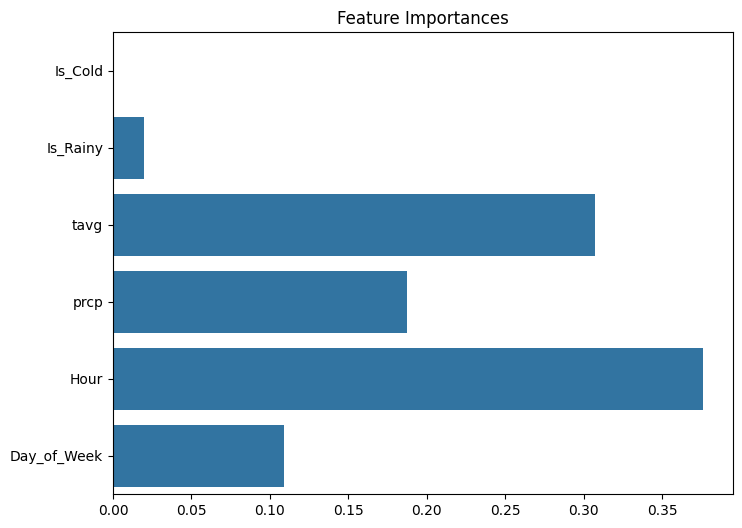

In [46]:
# Plot feature importances
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.show()

Confusion Matrix:

In [47]:
# Confusion Matrix (for classification)
# Discretize 'Daily Entries' into 'low', 'medium', 'high' categories
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_train_bins = discretizer.fit_transform(y_train.values.reshape(-1, 1)).astype(int).flatten()
y_test_bins = discretizer.transform(y_test.values.reshape(-1, 1)).astype(int).flatten()

In [48]:
# Discretize predictions
y_pred_bins = discretizer.transform(y_pred.reshape(-1, 1)).astype(int).flatten()

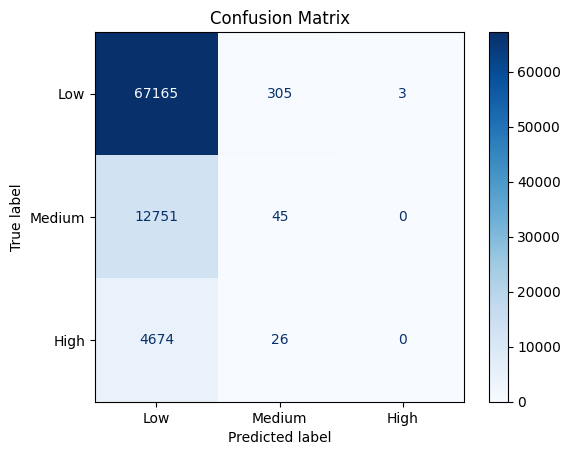

In [49]:
# Create confusion matrix
cm = confusion_matrix(y_test_bins, y_pred_bins)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Fetching Service Status Data using API:

In [56]:
    # Fetch Service Status Data
    url = "http://web.mta.info/status/serviceStatus.txt"

    # Send a request to the API
    response = requests.get(url)

    # Check the response status
    if response.status_code == 200:
        # Parse the XML response
        root = ET.fromstring(response.content)

        # Extract service status information for each subway line
        service_data = []
        for line in root.findall('.//line'):
            name = line.find('name').text
            status = line.find('status').text
            text = line.find('text').text if line.find('text') is not None else "No additional information"

            # Append service status data
            service_data.append({'line': name, 'status': status, 'info': text})

        # Convert to DataFrame for analysis
        service_status_df = pd.DataFrame(service_data)

        # Display the first few rows of service status data
        print(service_status_df.head())

   line                      status  \
0   123  PLANNED - STATIONS SKIPPED   
1   456  PLANNED - MULTIPLE IMPACTS   
2     7    PLANNED - PART SUSPENDED   
3   ACE  PLANNED - LOCAL TO EXPRESS   
4  BDFM        NO SCHEDULED SERVICE   

                                                info  
0  \n                <span class="TitlePlannedWor...  
1  \n                <span class="TitlePlannedWor...  
2  \n                <span class="TitlePlannedWor...  
3  \n                <span class="TitlePlannedWor...  
4  \n                <span class="TitlePlannedWor...  


In [60]:
# Manually mapping Line Names from turnstile data to the corresponding lines in service status
line_map = {
    'NQR456W': '456',   # Mapping 'NQR456W' to '456'
    'NQR': 'NQR',       # Mapping 'NQR' lines
    'ACE': 'ACE',       # ACE lines
    'BDFM': 'BDFM',     # BDFM lines
    '123': '123',       # 123 lines
    '7': '7',           # 7 line
    # Add more mappings here based on your turnstile data Line Name
}

# Applying the line mapping to turnstile data
turnstile_data['mapped_line'] = turnstile_data['Line Name'].map(line_map)

# Merging the turnstile data with service status data based on the mapped lines
subway_service_merged_data = pd.merge(
    turnstile_data, service_status_df,
    left_on='mapped_line', right_on='line', how='left'
)

# Display the merged dataset to verify
if not subway_service_merged_data.empty:
    print("Merged Data:")
    print(subway_service_merged_data.head())
else:
    print("Merged data is empty. Check the mapping or data preprocessing steps.")



Merged Data:
    C/A  Unit       SCP Line Name Division       Date      Time Description  \
0  A002  R051  02-00-00   NQR456W      BMT 2022-01-09  23:00:00     REGULAR   
1  A002  R051  02-00-00   NQR456W      BMT 2022-01-11  15:00:00     REGULAR   
2  A002  R051  02-00-00   NQR456W      BMT 2022-01-14  07:00:00     REGULAR   
3  A002  R051  02-00-00   NQR456W      BMT 2022-01-19  11:00:00     REGULAR   
4  A002  R051  02-00-00   NQR456W      BMT 2022-01-20  15:00:00     REGULAR   

   ENTRIES    EXITS  Daily Entries  Daily Exits mapped_line line  \
0  7677647  2652319            0.0          0.0         456  456   
1  7677977  2653100          330.0        781.0         456  456   
2  7678730  2654142          753.0       1042.0         456  456   
3  7679769  2655883         1039.0       1741.0         456  456   
4  7680121  2656380          352.0        497.0         456  456   

                       status  \
0  PLANNED - MULTIPLE IMPACTS   
1  PLANNED - MULTIPLE IMPACTS   
2  P

Entries on Rainy day vs Non Rainy Days:

<ipython-input-61-17eb4d36780e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is_Rainy', y='Daily Entries', data=rainy_day_data, palette='Blues')


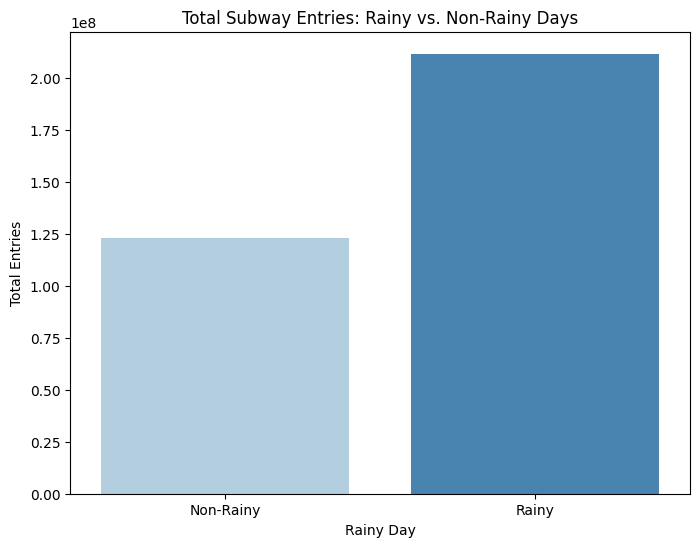

In [61]:
#Grouping data by Is_Rainy and calculate total daily entries
rainy_day_data = merged_data.groupby('Is_Rainy')['Daily Entries'].sum().reset_index()

#Plotting total entries on rainy vs. non-rainy days
plt.figure(figsize=(8, 6))
sns.barplot(x='Is_Rainy', y='Daily Entries', data=rainy_day_data, palette='Blues')
plt.xticks([0, 1], ['Non-Rainy', 'Rainy'])
plt.title('Total Subway Entries: Rainy vs. Non-Rainy Days')
plt.xlabel('Rainy Day')
plt.ylabel('Total Entries')
plt.show()


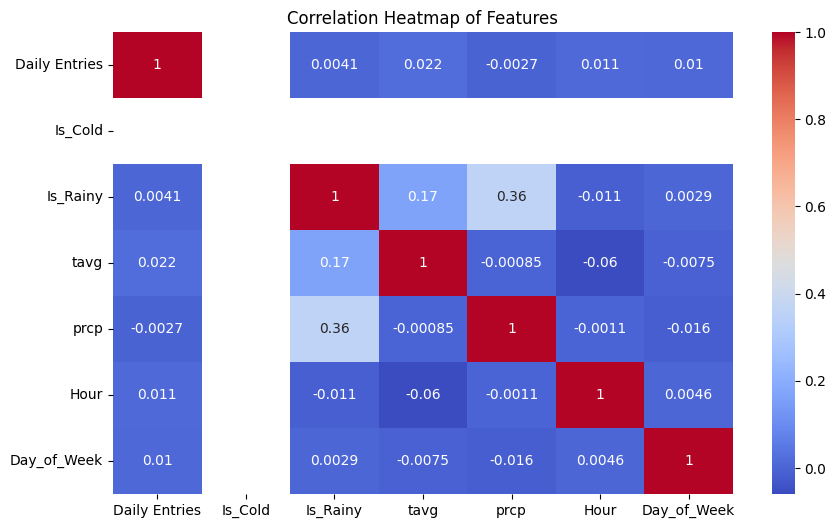

In [64]:
# Correlation heatmap of relevant features
plt.figure(figsize=(10, 6))
correlation_matrix = merged_data[['Daily Entries', 'Is_Cold', 'Is_Rainy', 'tavg', 'prcp', 'Hour', 'Day_of_Week']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

Next Steps: With the service status data successfully integrated, the next steps focus on:

1. Aggregating the data by day and analyzing weather impacts.
2. Building a robust predictive model using all available features.
3. Simulating potential scenarios to provide actionable insights.
4. Preparing the final presentation and report.